# Read in the data

In [19]:
import pandas as pd
import numpy
import re
import matplotlib.pyplot as plt

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [20]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [21]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [22]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [23]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [24]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [25]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [26]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [27]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

In [28]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

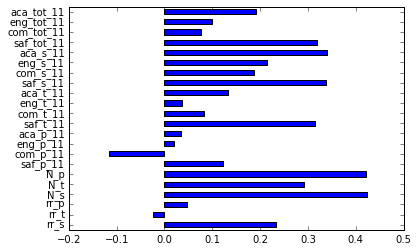

In [29]:
%matplotlib inline

correlations[survey_fields].plot.barh()

The number of student and parent respondents is positively correlated with SAT scores as well as response rate. So when students and parents seem to be more involved it positively correlates with SAT scores. One surprising correlation was that the teacher response rate is negatively correlated with SAT scores.

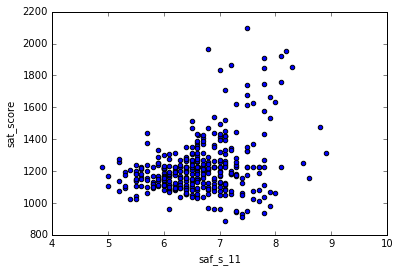

In [30]:
combined.plot.scatter('saf_s_11', 'sat_score')

You can see a positive correlation between safety scores and SAT scores, especially in scores above 7. There is a cloud of schools between 5 and 7 with a SAT score around 1200.

In [31]:
dist_grouped = combined.groupby("school_dist").mean()
dist_grouped['saf_s_11']

school_dist
01    6.768611
02    6.910660
03    6.716667
04    6.885714
05    6.314286
06    6.950000
07    6.800000
08    6.364697
09    6.655000
10    6.577273
11    6.186667
12    7.116667
13    6.407692
14    6.685714
15    6.177778
16    5.875000
17    6.007143
18    6.190909
19    6.150000
20    7.120000
21    6.390909
22    7.025000
23    6.233333
24    7.107692
25    6.912500
26    6.760000
27    6.390000
28    6.627273
29    6.075000
30    7.033333
31    6.530000
32    6.766667
Name: saf_s_11, dtype: float64

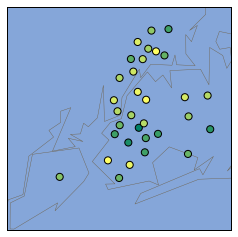

In [41]:
from mpl_toolkits.basemap import Basemap

m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

longitudes = dist_grouped['lon'].tolist()
latitudes = dist_grouped['lat'].tolist()

m.scatter(longitudes, latitudes, s=50, zorder=2, latlon=True, c=dist_grouped["saf_s_11"], cmap="summer")

plt.show()

Queens and Manhattan seem to have some of the lower safety scores while Brooklyn has some of the highest.

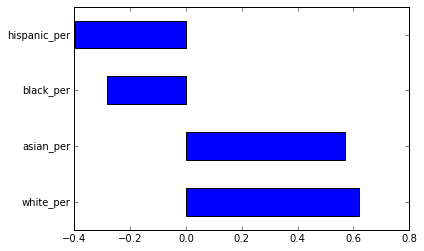

In [44]:
racial_cols = ["white_per", "asian_per", "black_per", "hispanic_per"]
correlations[racial_cols].plot.barh()

Black and Hispanic percentages have a negative correlation while White and Asian percentages have a positive correlation. 

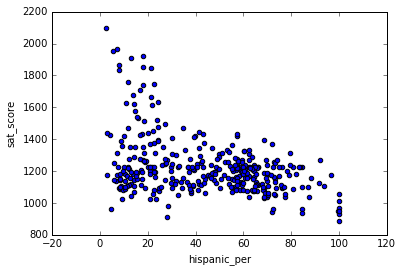

In [45]:
combined.plot.scatter('hispanic_per', 'sat_score')

Schools with around 100% hispanic populations score very poorly on the SAT.

In [46]:
high_hispanic = combined[combined['hispanic_per'] > 95]

In [48]:
high_hispanic['SCHOOL NAME']

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

These particular schools seem to cater to immigrants to help them learn and assimilate in America. This would help explain the low SAT scores.

In [49]:
low_hispanic = combined[combined['hispanic_per'] < 10]
low_hispanic['SCHOOL NAME']

37                                STUYVESANT HIGH SCHOOL
46       HIGH SCHOOL FOR DUAL LANGUAGE AND ASIAN STUDIES
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
192                          BEDFORD ACADEMY HIGH SCHOOL
194                            BENJAMIN BANNEKER ACADEMY
220                           BOYS AND GIRLS HIGH SCHOOL
223    ACADEMY FOR COLLEGE PREPARATION AND CAREER EXP...
226               THE HIGH SCHOOL FOR GLOBAL CITIZENSHIP
227                         SCHOOL FOR HUMAN RIGHTS, THE
228                  SCHOOL FOR DEMOCRACY AND LEADERSHIP
229    HIGH SCHOOL FOR YOUTH AND COMMUNITY DEVELOPMEN...
230        HIGH SCHOOL FOR SERVICE & LEARNING AT ERASMUS
231    SCIENCE, TECHNOLOGY AND RESEARCH EARLY COLLEGE...
235              MEDGAR EVERS COLLEGE PREPARATORY SCHOOL
236                             CLARA BARTON HIGH SCHOOL
237                           IT TAKES A VILLAGE ACADEMY
238                           B

These schools seem to attract some of the brightest students in the area and are academically demanding, leading to higher SAT schools. 

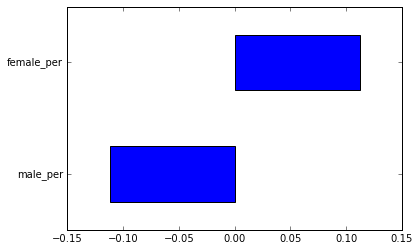

In [50]:
correlations[['male_per','female_per']].plot.barh()

Female percentage correlates positively with SAT scores while Male percentages correlates negatively at the exact same value.

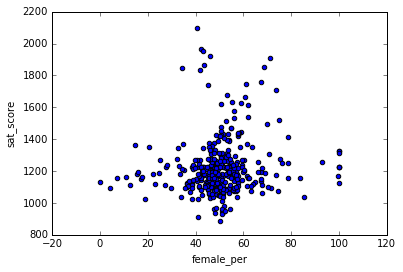

In [51]:
combined.plot.scatter('female_per', 'sat_score')

In [52]:
high_female = combined[combined['female_per'] > 60]
high_female['SCHOOL NAME']

5                         BARD HIGH SCHOOL EARLY COLLEGE
9                  HIGH SCHOOL OF HOSPITALITY MANAGEMENT
14                          LOWER MANHATTAN ARTS ACADEMY
15     URBAN ASSEMBLY SCHOOL OF BUSINESS FOR YOUNG WO...
16                             GRAMERCY ARTS HIGH SCHOOL
22              PROFESSIONAL PERFORMING ARTS HIGH SCHOOL
26                         ELEANOR ROOSEVELT HIGH SCHOOL
27                                MILLENNIUM HIGH SCHOOL
29     HIGH SCHOOL FOR HEALTH PROFESSIONS AND HUMAN S...
34                             MANHATTAN VILLAGE ACADEMY
40                          TALENT UNLIMITED HIGH SCHOOL
43        REPERTORY COMPANY HIGH SCHOOL FOR THEATRE ARTS
45                                NEW DESIGN HIGH SCHOOL
48              RICHARD R. GREEN HIGH SCHOOL OF TEACHING
49                 THE HIGH SCHOOL OF FASHION INDUSTRIES
58     WADLEIGH SECONDARY SCHOOL FOR THE PERFORMING &...
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HI

In [53]:
combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment']

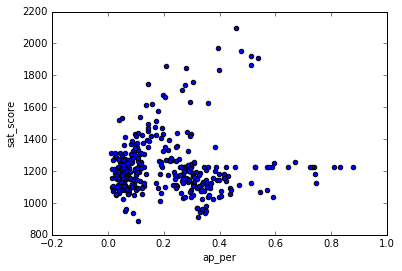

In [54]:
combined.plot.scatter('ap_per', 'sat_score')

You can see some positive correlation between the percentage of AP test takers and SAT scores. There is also an odd, almost line, just above 